In [55]:
from dotenv import load_dotenv
load_dotenv()

True

In [56]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [57]:
llm.invoke('hello')

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BhEy6aeZVwAeaV98cGZfzYUo8POX3', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--080ffbcb-775e-4aa7-b376-3e7d40dc64e4-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [58]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

# 1. Indexing

In this guide we’ll build an app that answers questions about the website's content. 
Website link : 

In [59]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Load the website contents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

In [60]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


Our loaded document is too long to fit into the context window of many models. Even for those models that could fit the full post in their context window, models can struggle to find information in very long inputs.

To handle this we’ll split the Document into chunks for embedding and vector storage. This should help us retrieve only the most relevant parts of the blog post at run time.

In [61]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


In [62]:
all_splits[:3]

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 8}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from

Storing documents
Now we need to index our 63 text chunks so that we can search over them at runtime. Following the semantic search tutorial, our approach is to embed the contents of each document split and insert these embeddings into a vector store. Given an input query, we can then use vector search to retrieve relevant documents.

In [63]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['e8a481cc-0276-499a-9286-d7683cac8b9d', '6b201e7f-d28e-462a-9b1e-de95d9224d0d', '107d88ff-4526-4eed-94a6-cb6b80a17565']


# 2. Retrieval and Generation

Now let’s write the actual application logic. We want to create a simple application that takes a user question, searches for documents relevant to that question, passes the retrieved documents and initial question to a model, and returns an answer.

In [64]:
from langchain import hub

# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt") 

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


To use LangGraph, we need to define three things:

The state of our application;
The nodes of our application (i.e., application steps);
The "control flow" of our application (e.g., the ordering of the steps).
State:
The state of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically a TypedDict, but can also be a Pydantic BaseModel.

For a simple RAG application, we can just keep track of the input question, retrieved context, and generated answer:

In [65]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

Let's start with a simple sequence of two steps: retrieval and generation.

In [66]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

Our retrieval step simply runs a similarity search using the input question, and the generation step formats the retrieved context and original question into a prompt for the chat model.

Control flow
Finally, we compile our application into a single graph object. In this case, we are just connecting the retrieval and generation steps into a single sequence.

In [67]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

LangGraph also comes with built-in utilities for visualizing the control flow of your application:

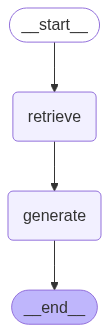

In [68]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

The benefits of LangGraph include:

Support for multiple invocation modes: this logic would need to be rewritten if we wanted to stream output tokens, or stream the results of individual steps;
Automatic support for tracing via LangSmith and deployments via LangGraph Platform;
Support for persistence, human-in-the-loop, and other features.


Let's test our application! LangGraph supports multiple invocation modes, including sync, async, and streaming.

In [69]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='b0896846-03d0-4cf2-a1e0-5e0c21981bf6', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool,

Stream steps:

In [70]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='b0896846-03d0-4cf2-a1e0-5e0c21981bf6', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to a

In [71]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| decomposition| is| a| method| of| breaking| down| complex| tasks| into| smaller| and| simpler| steps| using| prompts| or| task|-specific| instructions|,| either| by| L|LM| or| human| inputs|.| In| some| cases|,| task| decomposition| can| also| involve| external| classical| planners| like| in| the| L|LM|+|P| approach|,| which| outs|ources| the| planning| step| to| an| external| tool| for| long|-h|or|izon| planning| based| on| P|DDL|.| Techniques| like| Chain| of| Thought| and| Tree| of| Thoughts| help| enhance| model| performance| by| decom|posing| tasks| into| manageable| steps| and| exploring| multiple| reasoning| possibilities| at| each| step|.||